# **Fine-Tuning DistilBERT on the Financial PhraseBank**


# Install Dependencies and Import Libraries

In [1]:
!pip install transformers datasets evaluate accelerate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score
)
from sklearn.preprocessing import label_binarize

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)

from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


# Load PhraseBank Data

In [2]:
def load_phrasebank(path):
    texts = []
    labels = []

    with open(path, "r", encoding="latin1") as f:
        for line in f:
            if "@positive" in line:
                labels.append(2)
                texts.append(line.replace("@positive", "").strip())
            elif "@neutral" in line:
                labels.append(1)
                texts.append(line.replace("@neutral", "").strip())
            elif "@negative" in line:
                labels.append(0)
                texts.append(line.replace("@negative", "").strip())

    return pd.DataFrame({"text": texts, "label": labels})

df = load_phrasebank("data/Sentences_75Agree.txt")
print("Dataset size:", len(df))
df.head()

Dataset size: 3453


,text,label
0,"According to Gran , the company has no plans t...",1
1,With the new production plant the company woul...,2
2,"For the last quarter of 2010 , Componenta 's n...",2
3,"In the third quarter of 2010 , net sales incre...",2
4,Operating profit rose to EUR 13.1 mn from EUR ...,2


# Training/Testing Split

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

train_df.label.value_counts(), test_df.label.value_counts()

(label
 1    1717
 2     709
 0     336
 Name: count, dtype: int64,
 label
 1    429
 2    178
 0     84
 Name: count, dtype: int64)

# Tokenizer + Tokenization (Input Encoding)

In [4]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

# Hyperparameter Tuning

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

learning_rates = [1e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]

tuning_results = []

for lr in learning_rates:
    for bs in batch_sizes:

        tune_train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
        tune_val_loader = DataLoader(test_ds, batch_size=bs)

        model_hp = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=3
        ).to(device)

        optimizer_hp = AdamW(model_hp.parameters(), lr=lr)

        model_hp.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in tune_train_loader:
            optimizer_hp.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model_hp(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer_hp.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        model_hp.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tune_val_loader:
                logits = model_hp(
                    input_ids=batch["input_ids"].to(device),
                    attention_mask=batch["attention_mask"].to(device)
                ).logits

                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == batch["labels"].to(device)).sum().item()
                total_val += batch["labels"].size(0)

        val_acc = correct_val / total_val

        print(f"LR={lr}, Batch={bs}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        tuning_results.append({
            "learning_rate": lr,
            "batch_size": bs,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

best_config = max(tuning_results, key=lambda x: x["val_acc"])
best_config

Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LR=1e-05, Batch=8, Train Acc=0.8009, Val Acc=0.9291


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LR=1e-05, Batch=16, Train Acc=0.7596, Val Acc=0.9175


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LR=3e-05, Batch=8, Train Acc=0.8494, Val Acc=0.9407


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LR=3e-05, Batch=16, Train Acc=0.8342, Val Acc=0.9407


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LR=5e-05, Batch=8, Train Acc=0.8599, Val Acc=0.9378


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LR=5e-05, Batch=16, Train Acc=0.8335, Val Acc=0.9378


{'learning_rate': 3e-05,
 'batch_size': 8,
 'train_acc': 0.8493845039826213,
 'val_acc': 0.9406657018813314}

# Manual Hyperparameter Tuning & Training Loop

In [6]:
best_lr = best_config["learning_rate"]
best_bs = best_config["batch_size"]

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

train_loader = DataLoader(train_ds, batch_size=best_bs, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=best_bs)

optimizer = AdamW(model.parameters(), lr=best_lr)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
num_epochs = 3
train_losses = []
train_accuracies = []
val_accuracies = []

model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    model.train()

    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f} — Val Acc: {val_accuracy:.4f}")

Epoch 1/3, Avg Loss: 0.0310, Train Acc: 0.9906 — Val Acc: 0.9392
Epoch 2/3, Avg Loss: 0.0386, Train Acc: 0.9891 — Val Acc: 0.9522
Epoch 3/3, Avg Loss: 0.0199, Train Acc: 0.9928 — Val Acc: 0.9305


# Results Plots

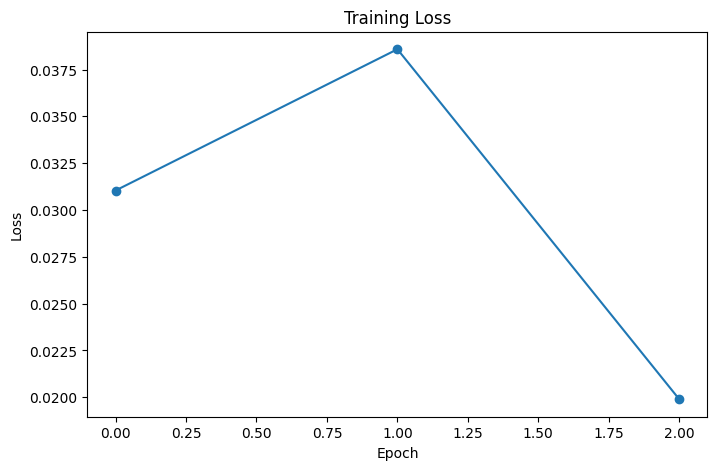

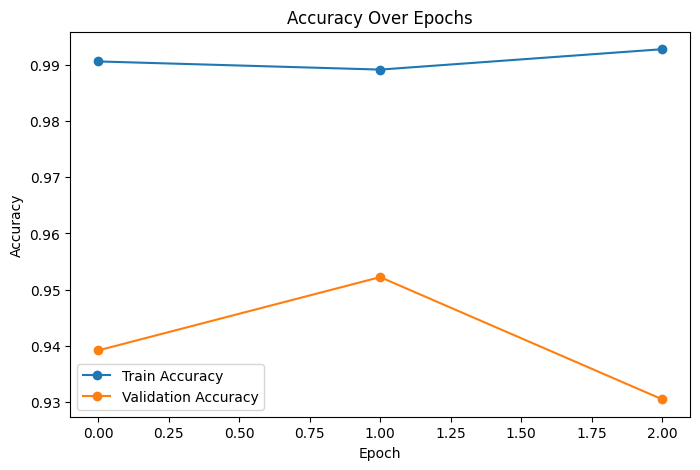

In [11]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_accuracies, marker='o', label="Train Accuracy")
plt.plot(val_accuracies, marker='o', label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Test Accuracy: 0.9305354558610709
              precision    recall  f1-score   support

    negative       0.94      0.87      0.90        84
     neutral       0.95      0.96      0.95       429
    positive       0.89      0.90      0.89       178

    accuracy                           0.93       691
   macro avg       0.92      0.91      0.92       691
weighted avg       0.93      0.93      0.93       691



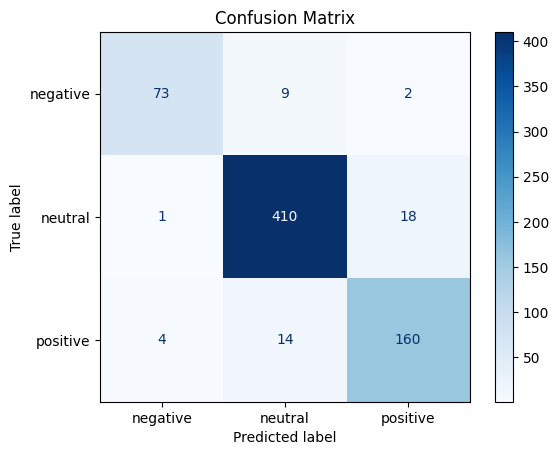

Class 0 metrics:
  TP=73, TN=602, FP=5, FN=11
Class 1 metrics:
  TP=410, TN=239, FP=23, FN=19
Class 2 metrics:
  TP=160, TN=493, FP=20, FN=18


In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(batch["labels"].numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

for cls in range(3):
    TP = cm[cls, cls]
    FP = cm[:, cls].sum() - TP
    FN = cm[cls, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"Class {cls} metrics:")
    print(f"  TP={TP}, TN={TN}, FP={FP}, FN={FN}")

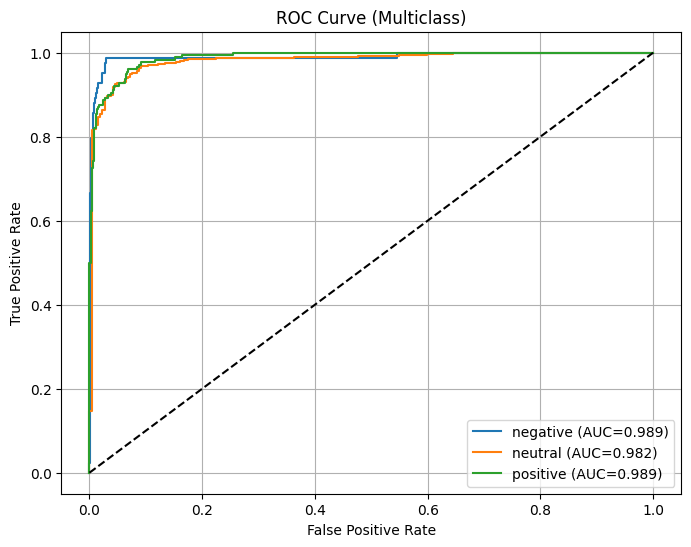

In [13]:
labels_bin = label_binarize(all_labels, classes=[0,1,2])

plt.figure(figsize=(8,6))

for i, cls in enumerate(["negative", "neutral", "positive"]):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend()
plt.grid()
plt.show()

In [14]:
model.save_pretrained("/content/finphrase_manual_model")
tokenizer.save_pretrained("/content/finphrase_manual_model")

print("Model saved to /content/finphrase_manual_model")

Model saved to /content/finphrase_manual_model


In [15]:
def predict(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        pred = outputs.logits.argmax(-1).item()

    return ["negative", "neutral", "positive"][pred]

print(predict("The company reported strong revenue growth."))
print(predict("The financial results were disappointing."))

positive
negative
